# California Housing Prices

Using the California Housing prices dataset to create a sample dataset for the NannyML library.

## Enriching data

We want to change the data to add context related for our use case. This includes:

- A time aspect
- Partitioning the data
- Specifying a target to make the problem a classification problem

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
# Get the data
cali = fetch_california_housing(as_frame=True)
df = pd.concat([cali.data, cali.target], axis=1)
df.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


In [ ]:
# add artificiacl timestamp
timestamps = [dt.datetime(2020,1,1) + dt.timedelta(hours=x) for x in df.index]
df['timestamp'] = timestamps

# add partitions
train_beg = dt.datetime(2020,1,1)
train_end = dt.datetime(2020,10,1)
test_beg = dt.datetime(2020,10,1)
test_end = dt.datetime(2021,6,1)
df.loc[df['timestamp'].between(train_beg, train_end, inclusive='left'), 'partition'] = 'train'
df.loc[df['timestamp'].between(test_beg, test_end, inclusive='left'), 'partition'] = 'test'
df['partition'] = df['partition'].fillna('production')

In [ ]:
# create new classification target - house value higher than mean
df_train = df[df['partition']=='train']

df['clf_target'] = np.where(df['MedHouseVal'] > df_train['MedHouseVal'].median(), 1, 0)
df = df.drop('MedHouseVal', axis=1)

del df_train

In [ ]:
df['partition'].value_counts()

production    8232
train         6576
test          5832
Name: partition, dtype: int64

In [ ]:
df.groupby('partition')['timestamp'].max()

partition
production   2022-05-09 23:00:00
test         2021-05-31 23:00:00
train        2020-09-30 23:00:00
Name: timestamp, dtype: datetime64[ns]

In [ ]:
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,timestamp,partition,clf_target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,2022-05-09 19:00:00,production,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,2022-05-09 20:00:00,production,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,2022-05-09 21:00:00,production,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,2022-05-09 22:00:00,production,0
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,2022-05-09 23:00:00,production,0


## Adding a model

This is the model that we will want to monitor.

In [ ]:
# fit classifier
target = 'clf_target'
meta = 'partition'
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


df_train = df[df['partition']=='train']

clf = RandomForestClassifier(random_state=42)
clf.fit(df_train[features], df_train[target])
df['y_pred_proba'] = clf.predict_proba(df[features])[:,1]

In [ ]:
# Check roc auc scores
for partition_name, partition_data in df.groupby('partition', sort=False):
    print(partition_name, roc_auc_score(partition_data[target], partition_data['y_pred_proba']))

train 1.0
test 0.9079415179034716
production 0.8402458783370228


<AxesSubplot:ylabel='Density'>

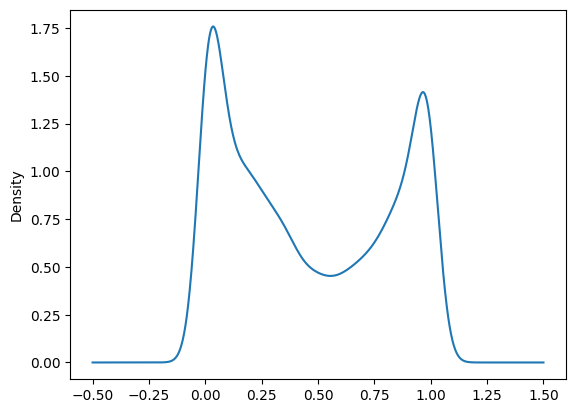

In [ ]:
df.y_pred_proba.plot.kde()

## Prepare data for NannyML

In [ ]:
df['y_pred'] = df['y_pred_proba'].map(lambda p: int(p >= 0.8))


In [ ]:
df_for_nanny = df[df['partition']!='train'].reset_index(drop=True)
df_for_nanny['partition'] = df_for_nanny['partition'].map({'test':'reference', 'production':'analysis'})
df_for_nanny['identifier'] = df_for_nanny.index

In [ ]:
df_ref = df_for_nanny[df_for_nanny['partition']=='reference'].copy()
df_ana = df_for_nanny[df_for_nanny['partition']=='analysis'].copy()
df_gt = df_ana[['identifier', 'clf_target']].copy()
df_ana = df_ana.drop('clf_target', axis=1)

In [ ]:
df_ref

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,timestamp,partition,clf_target,y_pred_proba,y_pred,identifier
0,9.8413,32.0,7.170040,1.014845,4353.0,2.937247,34.22,-118.19,2020-10-01 00:00:00,reference,1,0.99,1,0
1,8.3695,37.0,7.458746,1.062706,941.0,3.105611,34.22,-118.21,2020-10-01 01:00:00,reference,1,1.00,1,1
2,8.7200,44.0,6.163180,1.046025,668.0,2.794979,34.20,-118.18,2020-10-01 02:00:00,reference,1,1.00,1,2
3,7.4190,41.0,6.725166,0.973510,859.0,2.844371,34.20,-118.19,2020-10-01 03:00:00,reference,1,1.00,1,3
4,6.5530,41.0,7.120000,1.013333,680.0,3.022222,34.21,-118.19,2020-10-01 04:00:00,reference,1,1.00,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,2.7667,5.0,4.449198,1.187166,907.0,2.425134,33.69,-116.25,2021-05-31 19:00:00,reference,0,0.30,0,5827
5828,3.2833,9.0,9.628429,2.117207,825.0,2.057357,33.70,-116.22,2021-05-31 20:00:00,reference,0,0.20,0,5828
5829,3.8125,9.0,7.130909,2.163636,966.0,3.512727,33.76,-116.24,2021-05-31 21:00:00,reference,0,0.21,0,5829
5830,4.7195,6.0,6.745067,1.326584,4571.0,2.373313,33.74,-116.29,2021-05-31 22:00:00,reference,1,0.44,0,5830


df_ref.to_csv("california_housing_reference.csv", index=False)
df_ana.to_csv("california_housing_analysis.csv", index=False)
df_gt.to_csv("california_housing_analysis_gt.csv", index=False)